In [1]:
import torch
import umap
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [2]:
from hubersed.style import *
from hubersed.paths import PATHS

DATA_PATH = PATHS['DATA']
RESULTS_PATH = PATHS['RESULTS']

Missing colon in file PosixPath('/Users/ng27753/Astronomy_Research/hubersed/styles/apj.mplstyle'), line 30 ('    \\usepackage{amsmath}')
Missing colon in file PosixPath('/Users/ng27753/Astronomy_Research/hubersed/styles/apj.mplstyle'), line 31 ('    \\usepackage{amssymb}')


In [3]:
device = torch.device('cpu')

In [101]:
latent_space_dict = torch.load(DATA_PATH / 'desi_noise_spender_10latent_space.pt', map_location=device)

In [85]:
latents = latent_space_dict['latents']

A = latent_space_dict['A']
A = A.squeeze()

z = latent_space_dict['zs']

In [86]:
reducer = umap.UMAP(random_state=14, n_neighbors=5).fit(latents)

/Users/ng27753/Astronomy_Research/hubersed/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [87]:
embeddings = reducer.transform(latents)

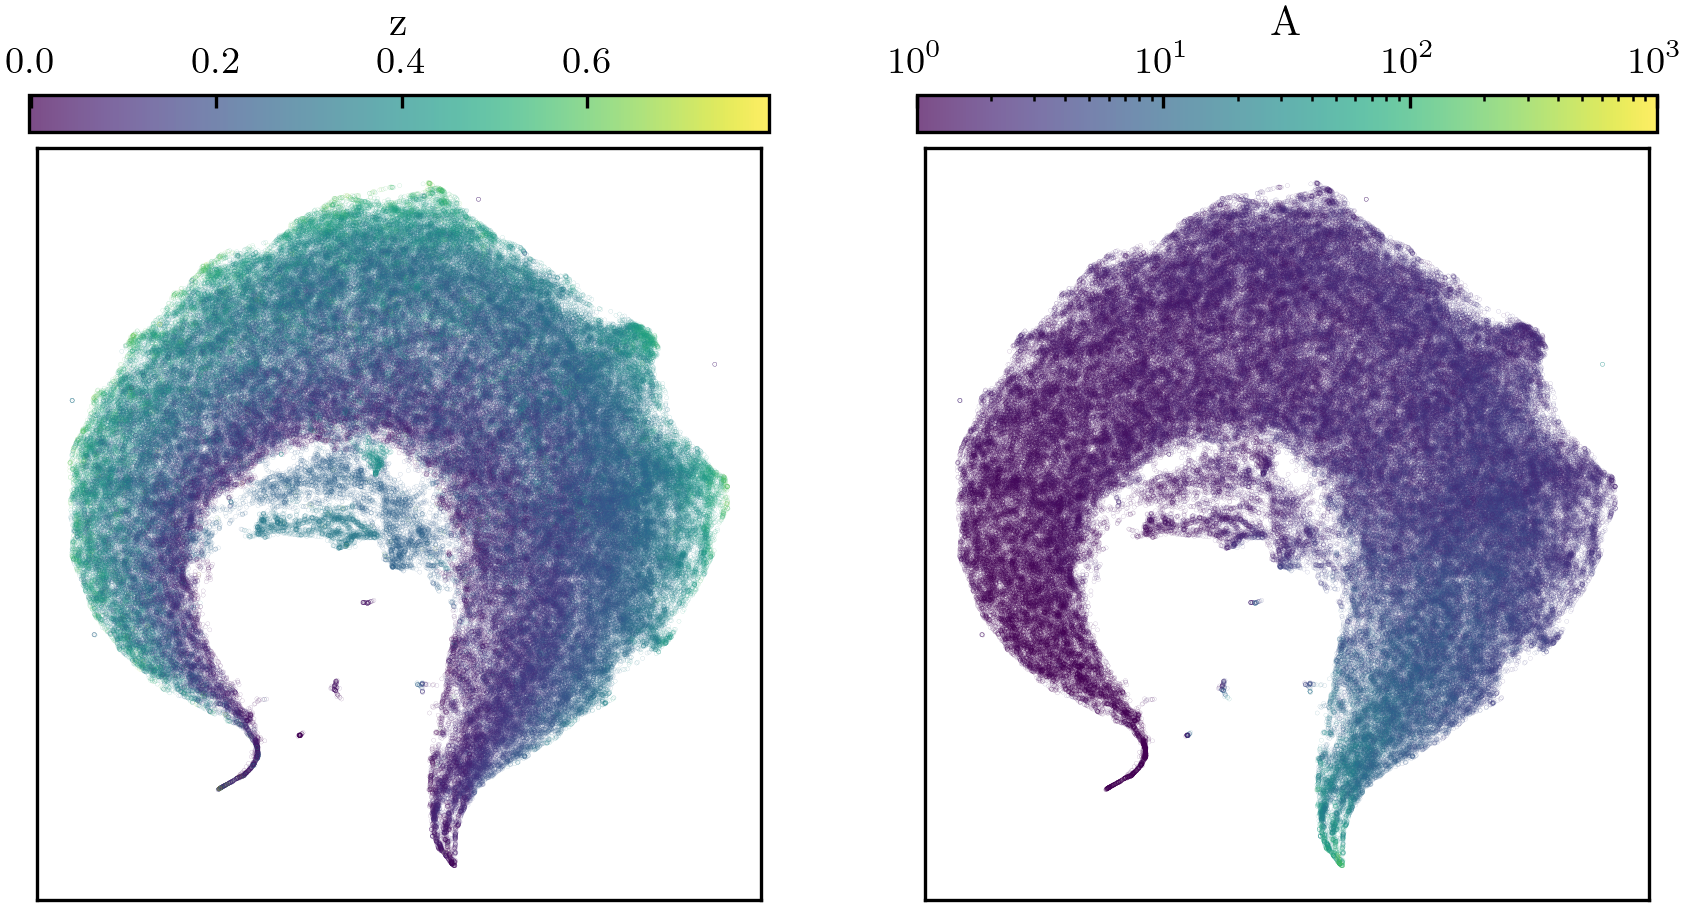

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(7., 3.5), dpi=300)
ax = ax.ravel()

# both ax should be equal aspect
for a in ax:
    a.set_aspect('equal', 'box')

scatter = ax[0].scatter(
    embeddings[:, 0], embeddings[:, 1],
    c=z, cmap='viridis',
    s=0.005, alpha=0.7,
    rasterized=True,
    marker='.'
)

# colorbar on top
cbar = fig.colorbar(
    scatter,
    ax=ax[0],
    orientation='horizontal',
    pad=0.02,          # distance between plot and colorbar
    fraction=0.05,     # thickness of colorbar
    location='top',
)
# range of colorbar 0 to 0.6
cbar.set_label('z')


import matplotlib as mpl
norm = mpl.colors.LogNorm(vmin=1, vmax=1000)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
scatter.set_cmap(cmap.cmap)

scatter = ax[1].scatter(embeddings[:, 0], embeddings[:, 1], c=A, s=.005, alpha=0.7, norm=norm, rasterized=True, marker='.')

cbar = plt.colorbar(scatter, ax=ax[1], orientation='horizontal', pad=0.02, fraction=0.05, location='top')
cbar.set_label('A')

# fig.tight_layout()

# no ticks
for a in ax:
    a.set_xticks([])
    a.set_yticks([])

fig.savefig(RESULTS_PATH / 'desi_noise_spender_10latent_space_umap.pdf', dpi=300)


In [4]:
# do for spectra

spender_spec = torch.load(DATA_PATH / 'spender_spec_6latent')
s_l = spender_spec['latents'].to(device)

prospector_spec = torch.load(DATA_PATH / 'prospector_noise_spec_6latent')
p_l = prospector_spec['latents'].to(device)

In [5]:
import numpy as np
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt

i, j = 0, 1

# -----------------------------
# 1. Get numpy arrays of points
# -----------------------------
# DESI (blue)
desi_xy = np.column_stack((
    s_l[:, i].detach().cpu().numpy(),
    s_l[:, j].detach().cpu().numpy()
))  # shape [N_desi, 2]

# Prospector (grey)
pros_xy = np.column_stack((
    p_l[:, i].detach().cpu().numpy(),
    p_l[:, j].detach().cpu().numpy()
))  # shape [N_pros, 2]

# -----------------------------
# 2. Build KD-tree on Prospector
# -----------------------------
tree = KDTree(pros_xy)

eps = 0.05

# For each DESI point, find all Prospector points within radius eps
# ind is a list of index arrays, one per DESI point
ind = tree.query_radius(desi_xy, r=eps)

# non-overlapping DESI points are those with ZERO neighbors in that radius
non_overlap_mask = np.array([len(idx) == 0 for idx in ind])

desi_non_overlap = desi_xy[non_overlap_mask]     # what you want
desi_overlap     = desi_xy[~non_overlap_mask]    # overlapping blues (optional)

# save non-overlapping mask for later
# torch.save(non_overlap_mask, DATA_PATH / 'desi_prospector_non_overlap_mask.pt')

In [ ]:
ax.scatter(s_l[:, i][non_overlap_mask], s_l[:, j][non_overlap_mask], s=0.5, alpha=0.5, color='k', label='DESI (non-overlap)', marker='x')

/var/folders/4v/k4xpjdyx3f1_c95lc_dlyhkr0000gq/T/ipykernel_18792/3784522957.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  sc = ax.scatter(s_l[:, i], s_l[:, j], s=0.05, alpha=0.8, label='DESI', color='C0', cmap='viridis', marker='.', vmin=0, vmax=0.6)


<Figure size 750x750 with 0 Axes>

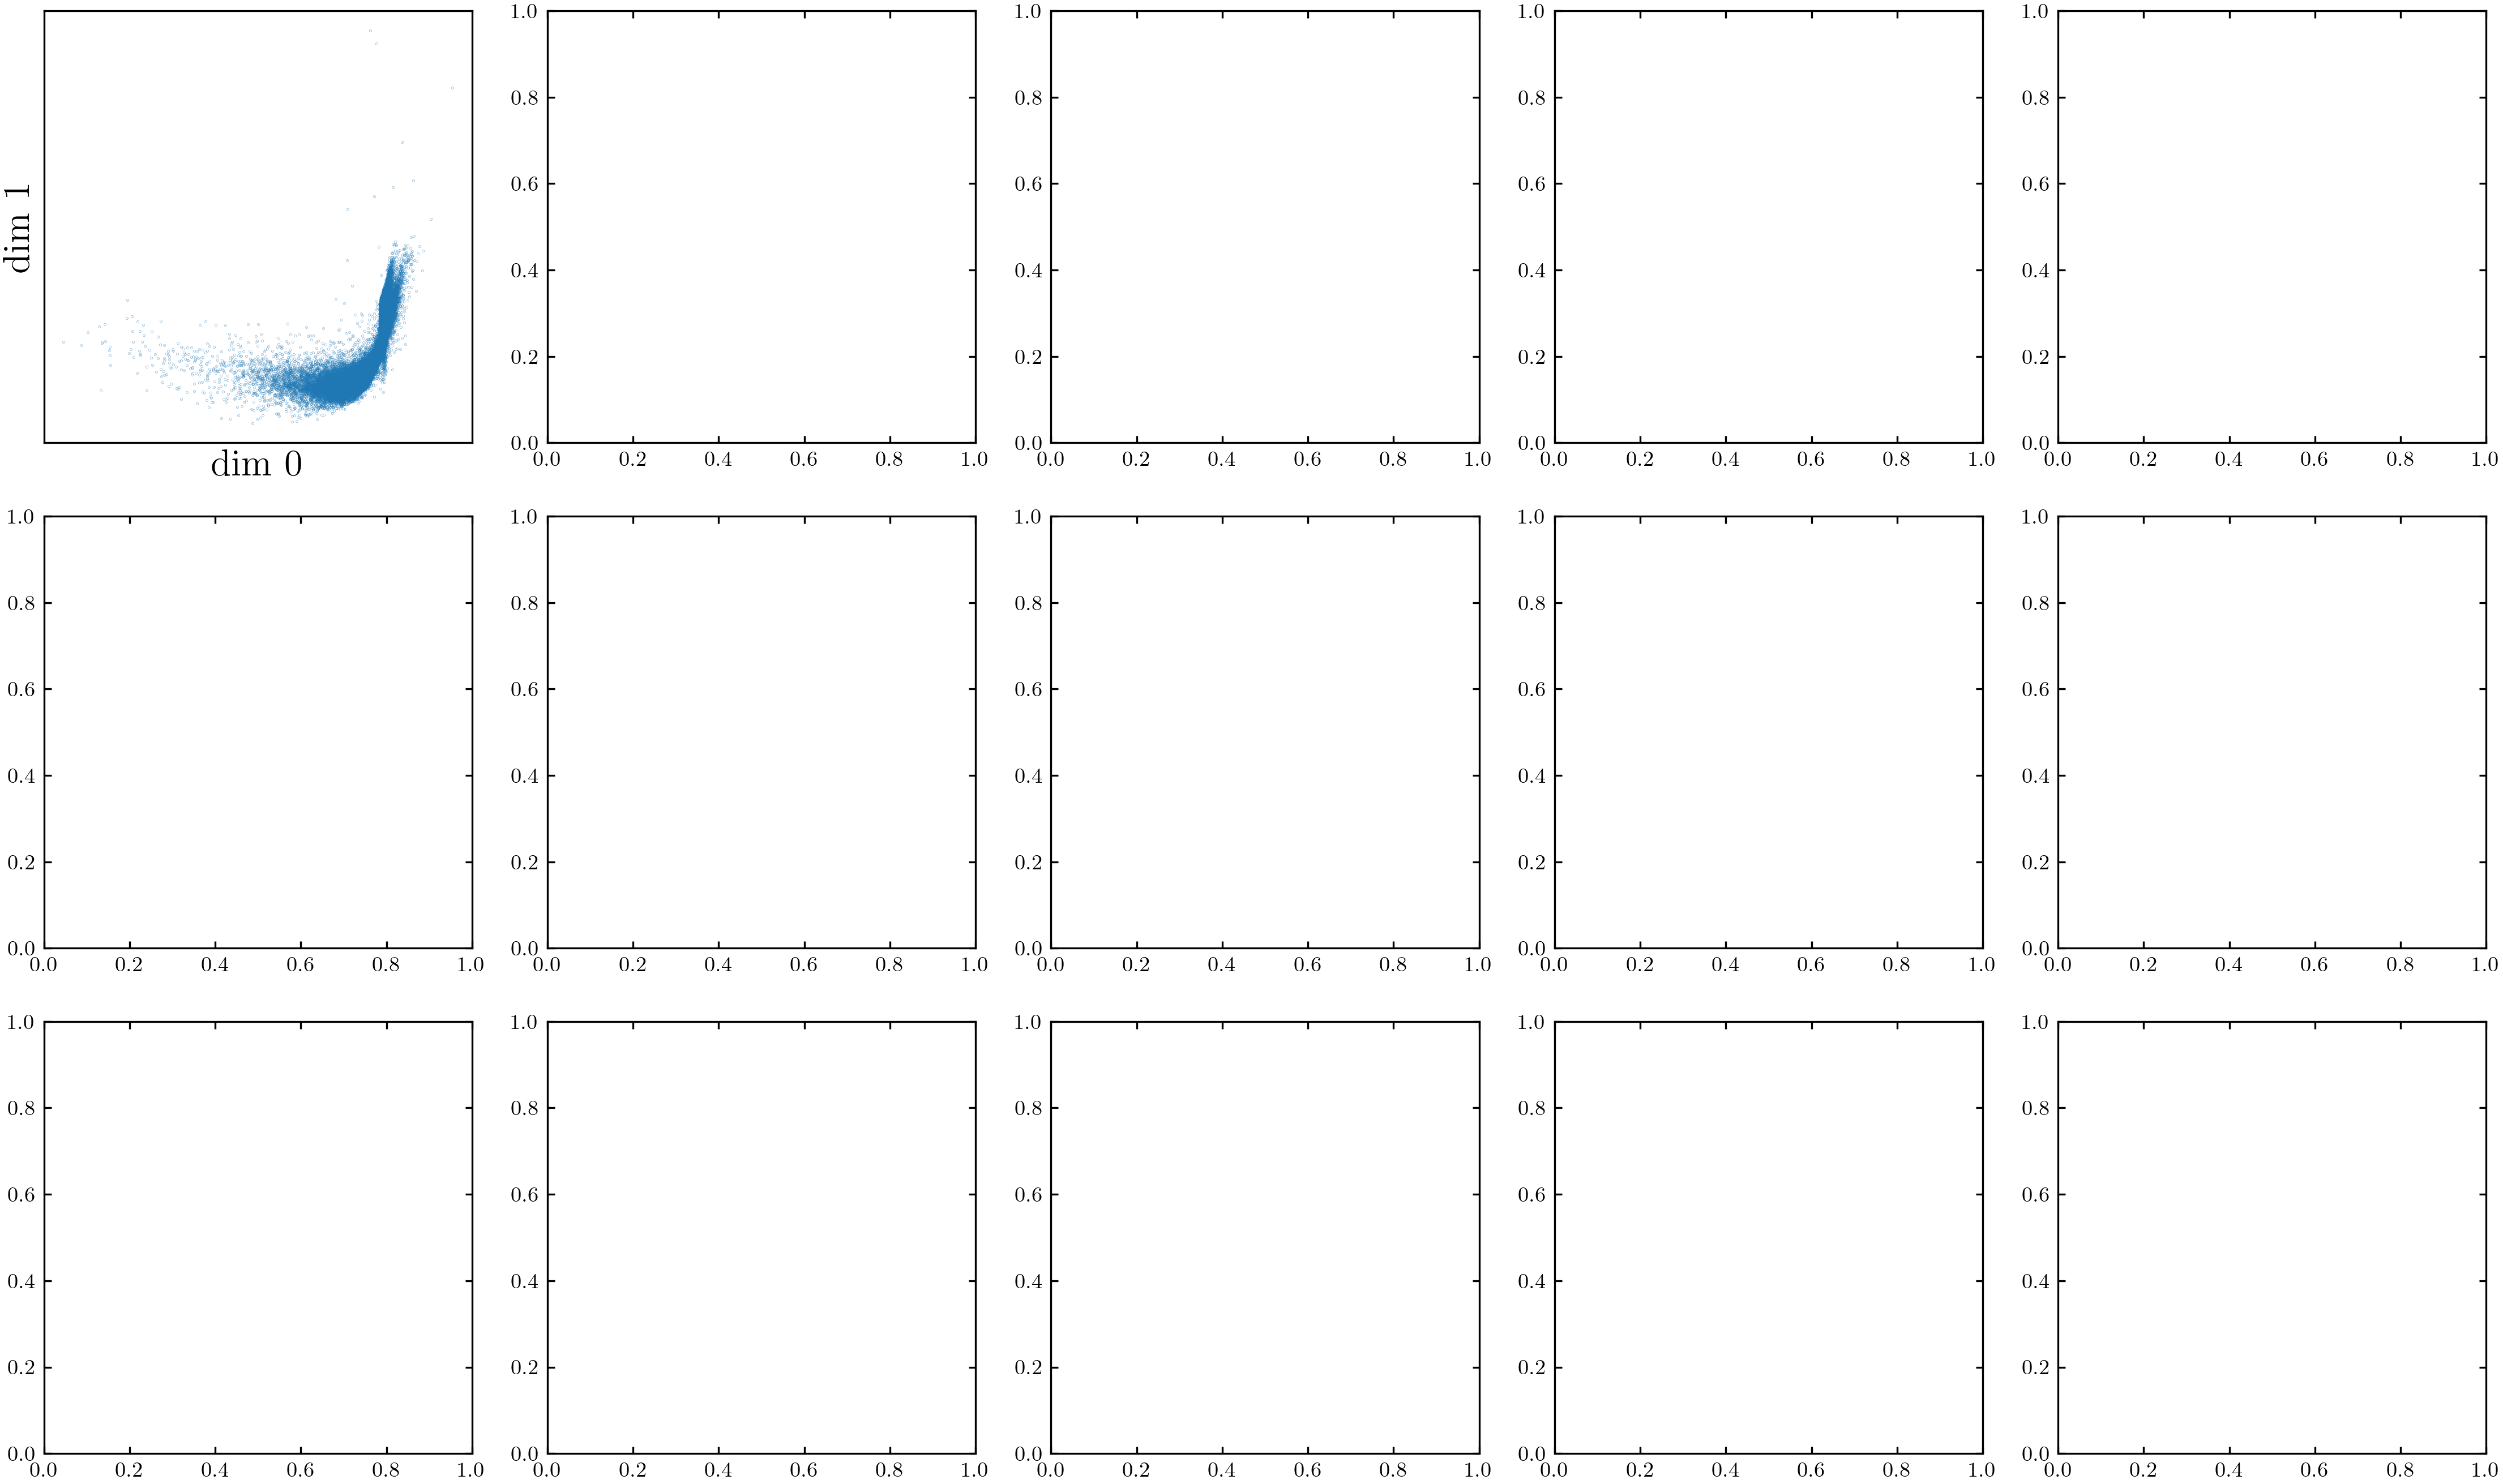

In [7]:
plt.figure(figsize=(5, 5), dpi=150)

N, D = s_l.shape

pairs = list(itertools.combinations(range(D), 2))  # [(0,1), (0,2), ..., (4,5)]
n_plots = len(pairs)

ncols = 5
nrows = int(np.ceil(n_plots / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
axes = axes.ravel()


for ax, (i, j) in zip(axes, pairs):
    sc = ax.scatter(s_l[:, i], s_l[:, j], s=0.05, alpha=0.8, label='DESI', color='C0', cmap='viridis', marker='.', vmin=0, vmax=0.6)
    # ax.scatter(p_l[:, i], p_l[:, j], s=0.005, alpha=0.3, color='C1', label='Prospector', marker='x')
    # ax.scatter(s_l[:, i][non_overlap_mask], s_l[:, j][non_overlap_mask], s=0.5, alpha=0.5, color='k', label='DESI (non-overlap)', marker='x')

    # from scipy.spatial import ConvexHull

    # # DESI
    # points_desi = np.vstack((x_desi.cpu(), y_desi.cpu())).T
    # hull_desi = ConvexHull(points_desi, qhull_options='QG4')
    # for simplex in hull_desi.simplices:
    #     ax.plot(points_desi[simplex, 0], points_desi[simplex, 1], 'C0--', alpha=0.7, label='DESI')
    
    # # Prospector
    # points_prospector = np.vstack((x_prospector.cpu(), y_prospector.cpu())).T
    # hull_prospector = ConvexHull(points_prospector)
    # for simplex in hull_prospector.simplices:
    #     ax.plot(points_prospector[simplex, 0], points_prospector[simplex, 1], 'C1--', alpha=0.7, label='Prospector')

    ax.set_xlabel(f"dim {i}", fontsize=16)
    ax.set_ylabel(f"dim {j}", fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])
    break

fig.tight_layout()
# fig.legend( ['DESI', 'Prospector', 'DESI (non-overlap)'], loc='upper center', markerscale=80, fontsize=20, ncol=3, bbox_to_anchor=(0.5, 1.04))
# fig.savefig(RESULTS_PATH / 'desi_prospector_6latent_pairwise_comparison.pdf', dpi=300)

In [6]:
desi_spectra = spender_spec['specs'].to(device)
desi_redshifts = spender_spec['zs'].to(device)

desi_non_overlap_spectra = desi_spectra[non_overlap_mask]
desi_non_overlap_redshifts = desi_redshifts[non_overlap_mask]
desi_non_overlap_latents = s_l[non_overlap_mask]

desi_overlap_spectra = desi_spectra[~non_overlap_mask]
desi_overlap_redshifts = desi_redshifts[~non_overlap_mask]
desi_overlap_latents = s_l[~non_overlap_mask]

In [7]:
min(desi_non_overlap_redshifts), max(desi_non_overlap_redshifts), desi_non_overlap_redshifts.shape

(tensor(-0.0006), tensor(0.7946), torch.Size([5014]))

In [8]:
from spender import load_model
from spender.data import desi

inst = desi.DESI()

model = load_model(str(DATA_PATH / 'spender_asc_run_6latent_zmax.pt'), instrument=inst, map_location=device, weights_only=False)

In [9]:
wave_obs = inst.wave_obs

In [10]:
import os
import numba
import numpy as np
import scipy.sparse

def centers2edges(centers):
    """Convert bin centers to bin edges, guessing at what you probably meant
    Args:
        centers (array): bin centers,
    Returns:
        array: bin edges, lenth = len(centers) + 1
    """
    centers = np.asarray(centers)
    edges = np.zeros(len(centers)+1)
    #- Interior edges are just points half way between bin centers
    edges[1:-1] = (centers[0:-1] + centers[1:]) / 2.0
    #- edge edges are extrapolation of interior bin sizes
    edges[0] = centers[0] - (centers[1]-edges[1])
    edges[-1] = centers[-1] + (centers[-1]-edges[-2])

    return edges

@numba.jit
def _trapz_rebin(x, y, edges, results):
    '''
    Numba-friendly version of trapezoidal rebinning
    See redrock.rebin.trapz_rebin() for input descriptions.
    `results` is pre-allocated array of length len(edges)-1 to keep results
    '''
    nbin = len(edges) - 1
    i = 0  #- index counter for output
    j = 0  #- index counter for inputs
    yedge = 0.0
    area = 0.0

    while i < nbin:
        #- Seek next sample beyond bin edge
        while x[j] <= edges[i]:
            j += 1

        #- What is the y value where the interpolation crossed the edge?
        yedge = y[j-1] + (edges[i]-x[j-1]) * (y[j]-y[j-1]) / (x[j]-x[j-1])

        #- Is this sample inside this bin?
        if x[j] < edges[i+1]:
            area = 0.5 * (y[j] + yedge) * (x[j] - edges[i])
            results[i] += area

            #- Continue with interior bins
            while x[j+1] < edges[i+1]:
                j += 1
                area = 0.5 * (y[j] + y[j-1]) * (x[j] - x[j-1])
                results[i] += area

            #- Next sample will be outside this bin; handle upper edge
            yedge = y[j] + (edges[i+1]-x[j]) * (y[j+1]-y[j]) / (x[j+1]-x[j])
            area = 0.5 * (yedge + y[j]) * (edges[i+1] - x[j])
            results[i] += area

        #- Otherwise the samples span over this bin
        else:
            ylo = y[j] + (edges[i]-x[j]) * (y[j] - y[j-1]) / (x[j] - x[j-1])
            yhi = y[j] + (edges[i+1]-x[j]) * (y[j] - y[j-1]) / (x[j] - x[j-1])
            area = 0.5 * (ylo+yhi) * (edges[i+1]-edges[i])
            results[i] += area

        i += 1

    for i in range(nbin):
        results[i] /= edges[i+1] - edges[i]

    return

def trapz_rebin(x, y, xnew=None, edges=None):
    """Rebin y(x) flux density using trapezoidal integration between bin edges
    Notes:
        y is interpreted as a density, as is the output, e.g.
        >>> x = np.arange(10)
        >>> y = np.ones(10)
        >>> trapz_rebin(x, y, edges=[0,2,4,6,8])  #- density still 1, not 2
        array([ 1.,  1.,  1.,  1.])
    Args:
        x (array): input x values.
        y (array): input y values.
        edges (array): (optional) new bin edges.
    Returns:
        array: integrated results with len(results) = len(edges)-1
    Raises:
        ValueError: if edges are outside the range of x or if len(x) != len(y)
    """
    if edges is None:
        edges = centers2edges(xnew)
    else:
        edges = np.asarray(edges)

    if edges[0] < x[0] or x[-1] < edges[-1]:
        raise ValueError('edges must be within input x range')

    result = np.zeros(len(edges)-1, dtype=np.float64)

    _trapz_rebin(x, y, edges, result)

    return result

In [14]:
s_l.shape

torch.Size([254976, 6])

In [11]:
wave_rebin = np.arange(model.wave_obs[0], model.wave_obs[-1], 10)[1:-1]

/var/folders/4v/k4xpjdyx3f1_c95lc_dlyhkr0000gq/T/ipykernel_7851/564539121.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  wave_rebin = np.arange(model.wave_obs[0], model.wave_obs[-1], 10)[1:-1]


/var/folders/4v/k4xpjdyx3f1_c95lc_dlyhkr0000gq/T/ipykernel_7851/3609748742.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  spec_rebin = trapz_rebin(np.array(model.wave_obs), np.array(desi_non_overlap_spectra[idx[i]].cpu()), xnew=wave_rebin)
/var/folders/4v/k4xpjdyx3f1_c95lc_dlyhkr0000gq/T/ipykernel_7851/3609748742.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  spec_rebin = trapz_rebin(np.array(model.wave_obs), np.array(desi_non_overlap_spectra[idx[i]].cpu()), xne

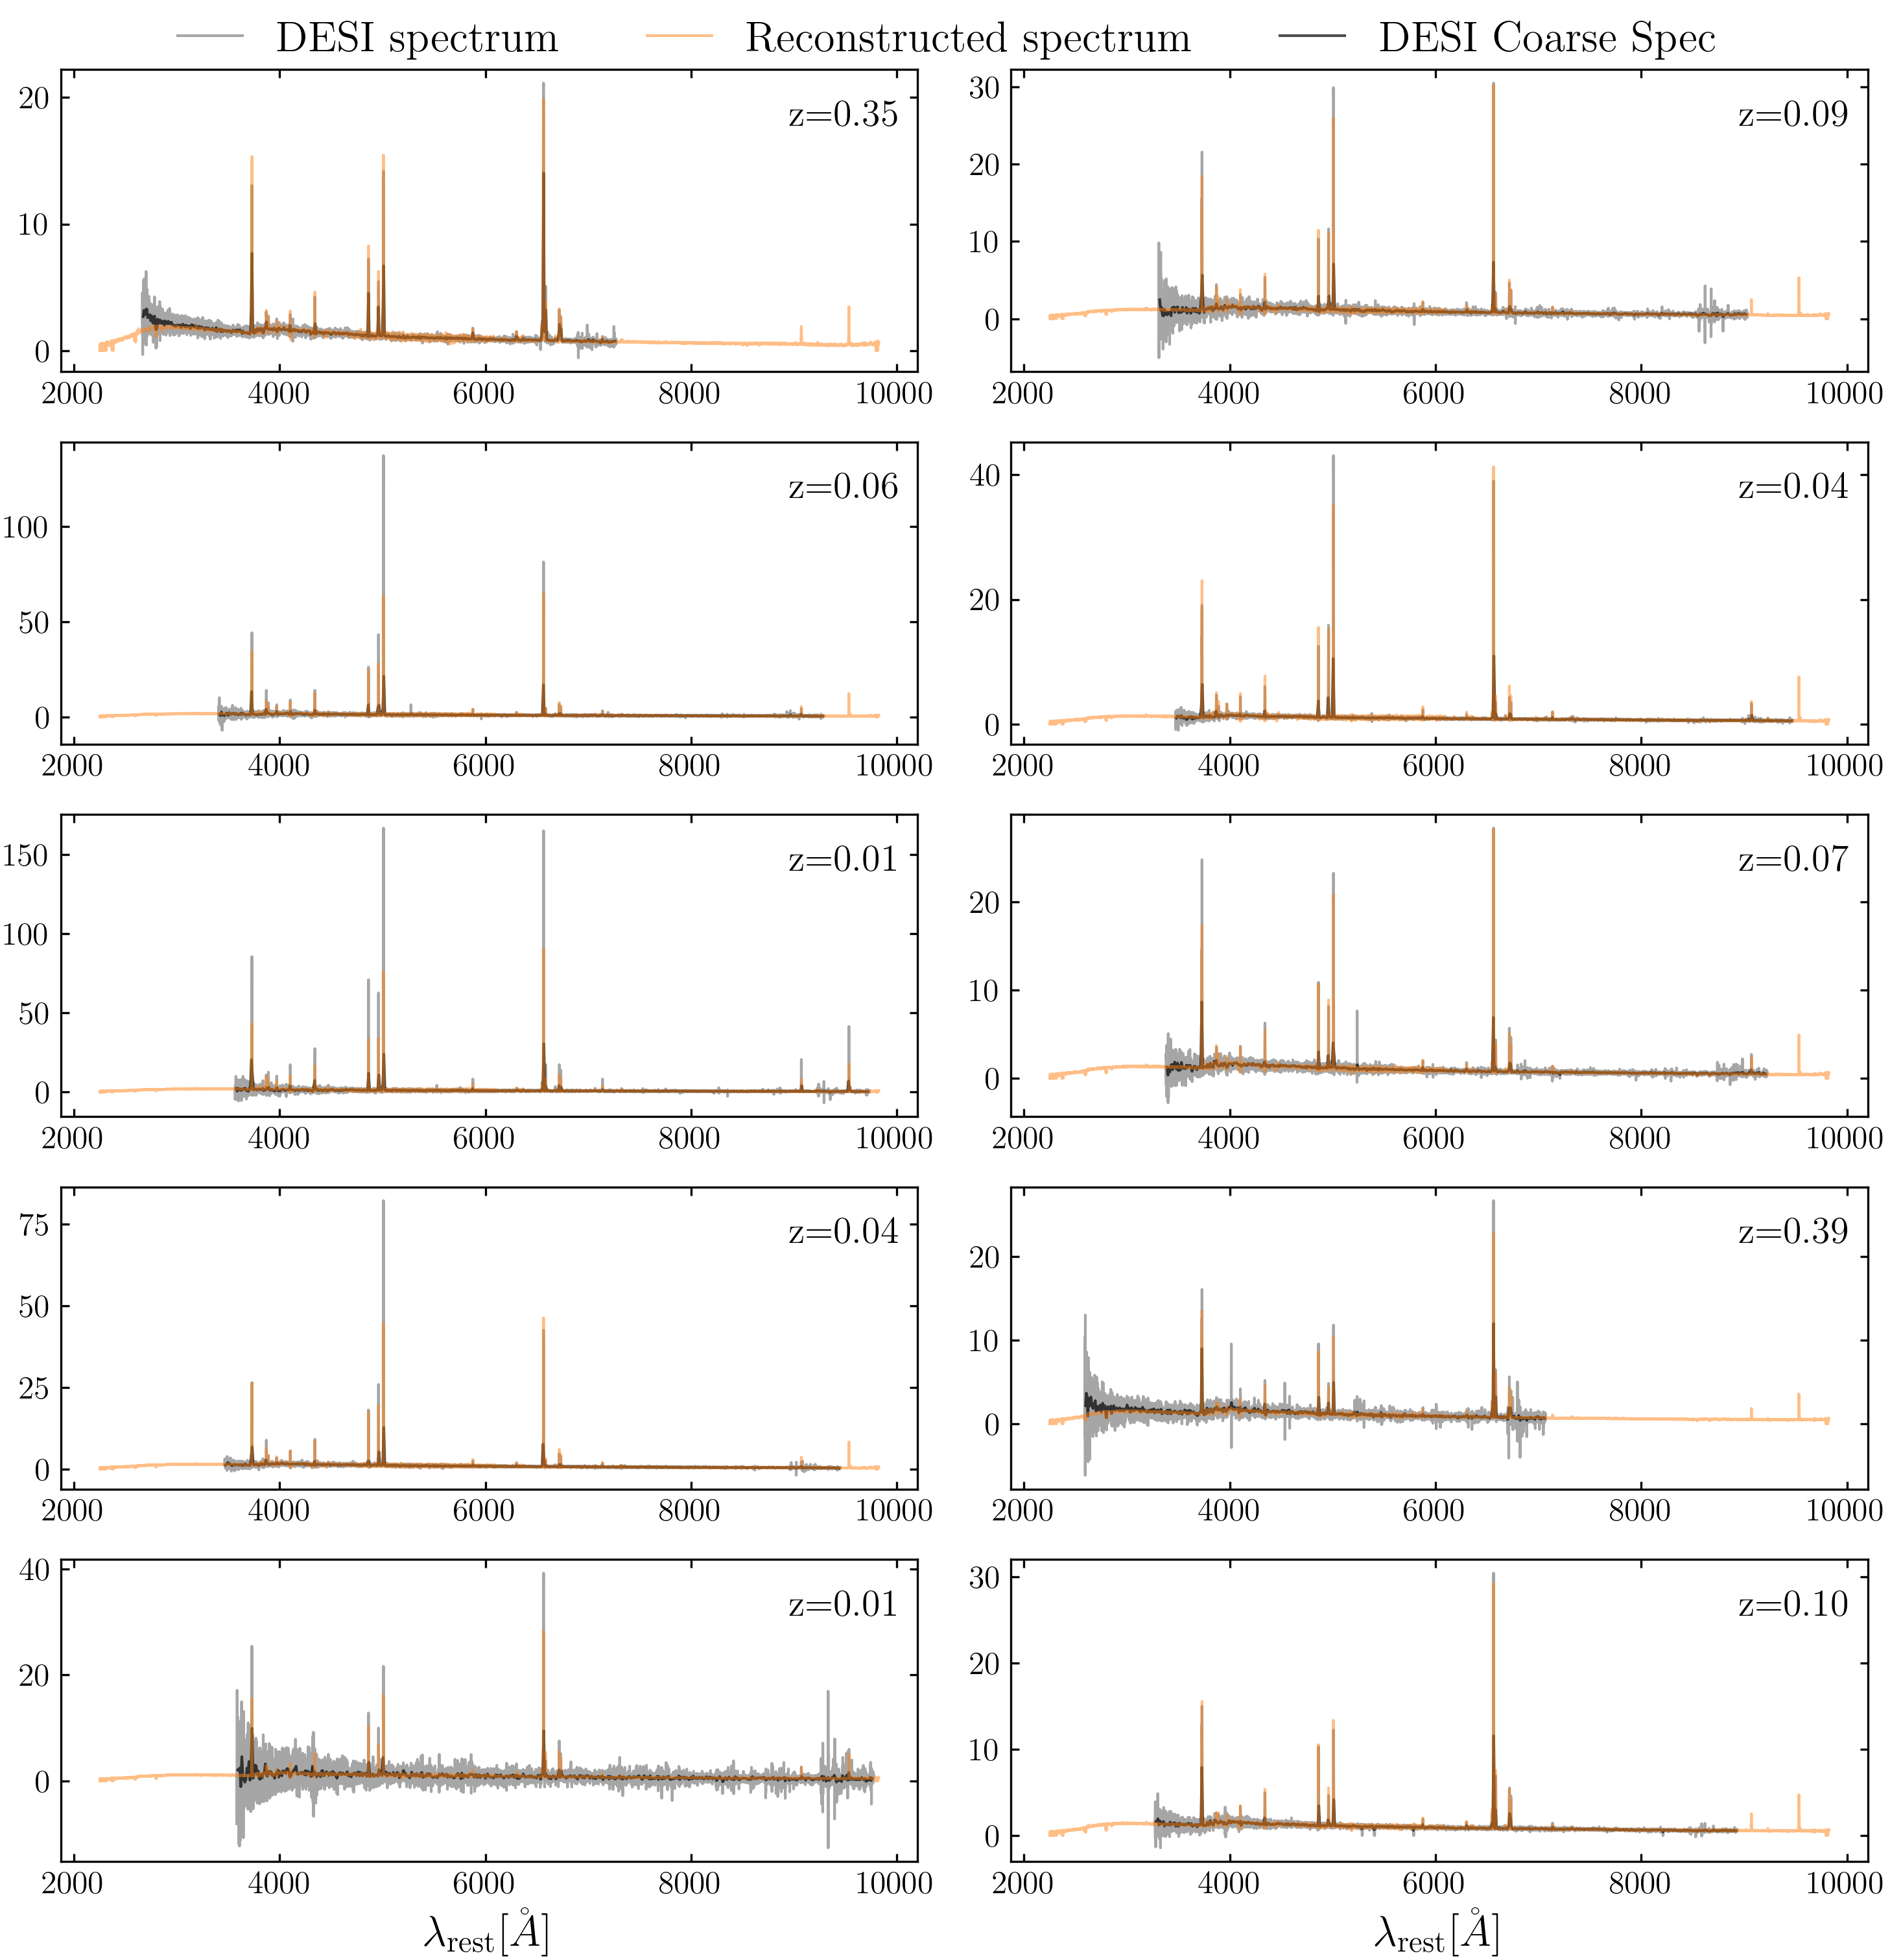

In [12]:
fig, ax = plt.subplots(5, 2, figsize=(10, 10))
ax = ax.ravel()
idx = np.random.choice(desi_non_overlap_latents.shape[0], size=10, replace=False)

for i in range(10):
    
    ax[i].plot(wave_obs.cpu() / (1.0 + desi_non_overlap_redshifts[idx[i]]), desi_non_overlap_spectra[idx[i]].cpu(), color='gray', alpha=0.7)
    
    # decode from latents
    with torch.no_grad():
        recon_spec = model.decode(desi_non_overlap_latents[idx[i]])
    ax[i].plot(model.wave_rest.cpu(), recon_spec.cpu(), color='C1', alpha=0.5, zorder=10)

    spec_rebin = trapz_rebin(np.array(model.wave_obs), np.array(desi_non_overlap_spectra[idx[i]].cpu()), xnew=wave_rebin)
    ax[i].plot(wave_rebin / (1.0 + desi_non_overlap_redshifts[idx[i]]), spec_rebin, color='k', alpha=0.7)
    

    ax[i].text(0.85, 0.9, f'z={desi_non_overlap_redshifts[idx[i]]:.2f}', transform=ax[i].transAxes, fontsize=14, verticalalignment='top')


ax[-1].set_xlabel(r'$\lambda_{\rm {rest}} [\AA]$', fontsize=16)
ax[-2].set_xlabel(r'$\lambda_{\rm {rest}} [\AA]$', fontsize=16)

# tick params
for a in ax:
    a.tick_params(axis='both', which='major', labelsize=12)

fig.tight_layout()
fig.legend(['DESI spectrum', 'Reconstructed spectrum', 'DESI Coarse Spec'], loc='upper center', fontsize=16, ncol=3, bbox_to_anchor=(0.5, 1.03))

In [ ]:
# obvi issue
# throughput in bluest end was artifically low, could have been the issue
# could be more than one issue:
# could be the emission lines - next step would be to mask them out, run with spender see if they lie within prospector latent space => more sure that continum can be recovered by prospector
# if that doesn't - star masking
# check the nearest neighbouring prospector spectra as well to the non-overlapping desi spectra

# check redshift distribution of non-overlapping spectra

# that way we can it's due to XYZ
# take the spectra, do a fit to prospector, see if it can recover the spectra, see where it's lacking -> but it's less physical interpretation